bluestore_lat_simple 0.08428 , simple_start 2020-05-12T09:54:40.757023-0500
bluestore_lat_simple 0.123164 , simple_start 2020-05-12T09:55:11.201221-0500
bluestore_lat_simple 0.123246 , simple_start 2020-05-12T09:55:11.201271-0500
bluestore_lat_simple 0.123225 , simple_start 2020-05-12T09:55:11.201303-0500
bluestore_lat_simple 0.12323 , simple_start 2020-05-12T09:55:11.201311-0500
bluestore_lat_simple 0.123169 , simple_start 2020-05-12T09:55:11.201382-0500
bluestore_lat_simple 0.123175 , simple_start 2020-05-12T09:55:11.201384-0500
bluestore_lat_simple 0.123142 , simple_start 2020-05-12T09:55:11.201428-0500
bluestore_lat_simple 0.123146 , simple_start 2020-05-12T09:55:11.201428-0500
bluestore_lat_simple 0.123146 , simple_start 2020-05-12T09:55:11.201438-0500
bluestore_lat_simple 0.123076 , simple_start 2020-05-12T09:55:11.201511-0500
bluestore_lat_simple 0.12304 , simple_start 2020-05-12T09:55:11.201557-0500
bluestore_lat_simple 0.122953 , simple_start 2020-05-12T09:55:11.201656-0500
bl

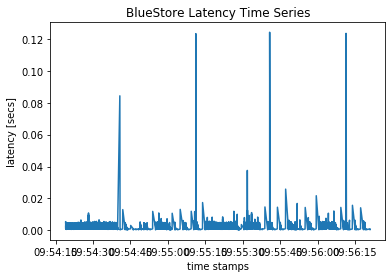

In [1]:
import sys
import numpy as np
from pandas import read_csv
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt
f1='dump_time_stamps_vec.csv'
data1=read_csv(f1, skiprows=10, parse_dates=True, squeeze=True, sep=',', header=None)
datalen = len(data1.values)

def check_bracket(str):
    if str == None:
        return "0"
    if str.startswith('['):
        return str[1:]
    if str.endswith(']'):
        return str[:-1]
    return str

# for bluestore latency
x_bs_lat = []
y_bs_lat = []


# process the time stamps
for i in range(datalen-1):
    # simple writes
    #if len(data1.values[i,:]) == len(data1.values[i+1,:]) and data1.values[i,2] == 'simple_s':
    if data1.values[i,2] == 'simple_s':
        # for first ctx
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1]))
        simple_s1 = parser.parse(check_bracket(data1.values[i,3]))
        aio_done1 = parser.parse(check_bracket(data1.values[i,5]))
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,7]))
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,9]))
        simple_e1 = parser.parse(check_bracket(data1.values[i,11]))
        # for second ctx
        '''ctr_ctx2 = parser.parse(check_bracket(data1.values[i+1,1]))
        simple_s2 = parser.parse(check_bracket(data1.values[i+1,3]))
        aio_done2 = parser.parse(check_bracket(data1.values[i+1,5]))
        flush_cmt_s2 = parser.parse(check_bracket(data1.values[i+1,7]))
        flush_cmt_e2 = parser.parse(check_bracket(data1.values[i+1,9]))
        simple_e2 = parser.parse(check_bracket(data1.values[i+1,11]))'''
        # sanity check of timestamps
        if simple_s1 < ctr_ctx1 or aio_done1 < simple_s1 or flush_cmt_s1 < aio_done1 or flush_cmt_e1 < flush_cmt_s1 or simple_e1 < flush_cmt_e1:
            print("simple writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_simple = simple_e1 - simple_s1
        x_bs_lat.append(simple_s1)
        y_bs_lat.append(bluestore_lat_simple.total_seconds())
        
        # spikes
        if bluestore_lat_simple.total_seconds() > 0.05:
            print("bluestore_lat_simple",bluestore_lat_simple.total_seconds(),", simple_start",check_bracket(data1.values[i,3]))

    # deferred writes
    elif data1.values[i,2] == 'deferred_s':
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1]))
        deferred_s1 = parser.parse(check_bracket(data1.values[i,3]))
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,5]))
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,7]))
        deferred_e1 = parser.parse(check_bracket(data1.values[i,9]))
        # sanity check of timestamps
        if deferred_s1 < ctr_ctx1 or flush_cmt_s1 < deferred_s1 or flush_cmt_e1 < flush_cmt_s1 or deferred_e1 < flush_cmt_e1:
            print("deferred writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_deferred = deferred_e1 - deferred_s1
        x_bs_lat.append(deferred_s1)
        y_bs_lat.append(bluestore_lat_deferred.total_seconds())
        
        # spikes
        if bluestore_lat_deferred.total_seconds() > 0.05:
            print("bluestore_lat_deferred",bluestore_lat_deferred.total_seconds(),", deferred_start",check_bracket(data1.values[i,3]))

# plot           
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.plot(x_bs_lat, y_bs_lat, label='4096 KiB')
ax.set(xlabel='time stamps', ylabel='latency [secs]', title='BlueStore Latency Time Series')
#plt.legend()
plt.show()
plt.close()
